# Dependencies

In [5]:
import numpy as np
import scipy as sp
import seaborn as sn
import pandas as pd
import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.animation
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import time
from IPython.display import HTML, Image, Video
from tqdm import tqdm
import os
import xarray as xr
import gc
import multiprocessing
import glob

from mystatsfunctions import OLSE,LMoments
from moarpalettes import get_palette

## Matplotlib rcparams setup:
plt.style.use('/home/leachl/Documents/Thesis/ancil/figure-style.mplstyle')
## textwidth of Thesis
textwidth = 5.848611111111111
## palette
palette = get_palette.color_blind().to_sn_palette()

%matplotlib inline

# Introduction
Create resolution schematic for the thesis introduction.

# Definitions

In [2]:
# definition to create outline of land-sea mask
def get_outline_segments(mapimg,bbox=[-180,180,-90,90]):

    # a vertical line segment is needed, when the pixels next to each other horizontally
    #   belong to diffferent groups (one is part of the mask, the other isn't)
    # after this ver_seg has two arrays, one for row coordinates, the other for column coordinates 
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])

    # the same is repeated for horizontal segments
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])

    # if we have a horizontal segment at 7,2, it means that it must be drawn between pixels
    #   (2,7) and (2,8), i.e. from (2,8)..(3,8)
    # in order to draw a discountinuous line, we add Nones in between segments
    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))

    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))

    # now we transform the list into a numpy array of Nx2 shape
    segments = np.array(l)

    # now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points

    x0,x1,y0,y1=bbox
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]

    return segments.T

# Get data

In [3]:
ifs_fg = xr.open_dataset('/home/leachl/Documents/Random_coding/Oxford@home talk/data-for-figs/ERA5_windgust_oct_ifs.nc')
ifs_fg = ifs_fg.assign_coords(lon=(ifs_fg.lon+180)%360-180).sortby('lon')
had_fg = xr.open_dataset('/home/leachl/Documents/Random_coding/Oxford@home talk/data-for-figs/ERA5_windgust_oct_had.nc')
had_fg = had_fg.assign_coords(lon=(had_fg.lon+180)%360-180).sortby('lon')

ifs_lsm = xr.open_dataset('/home/leachl/Documents/Random_coding/Oxford@home talk/data-for-figs/IFS_lsm_r.nc').squeeze()
ifs_lsm = ifs_lsm.assign_coords(lon=(ifs_lsm.lon+180)%360-180).sortby('lon')
had_lsm = xr.open_dataset('/home/leachl/Documents/Random_coding/Oxford@home talk/data-for-figs/IFS_lsm_r_had.nc').squeeze()
had_lsm = had_lsm.assign_coords(lon=(had_lsm.lon+180)%360-180).sortby('lon')

# Generate plot

[None, None]

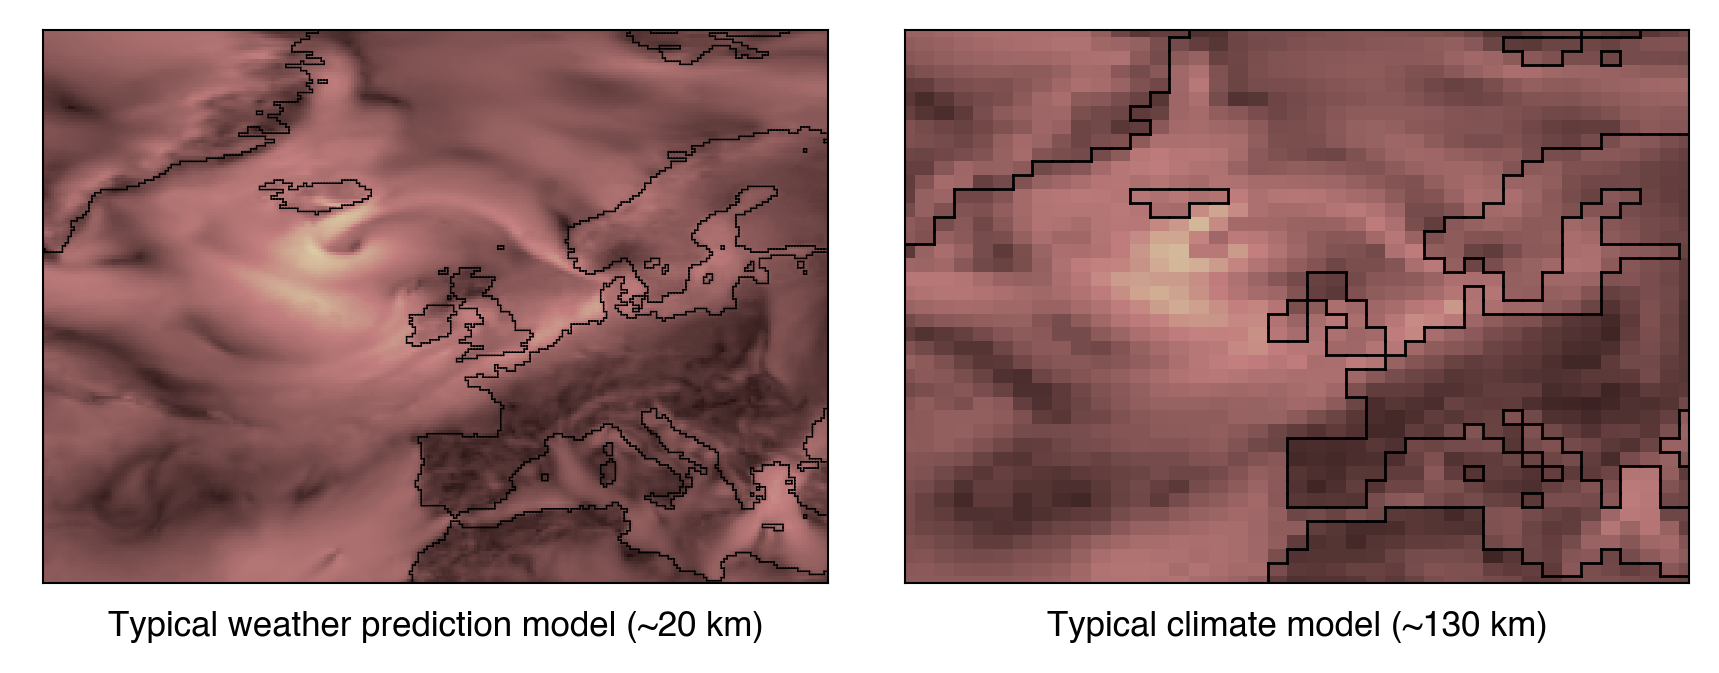

In [135]:
time = ifs_fg.time.values[0]

fig = plt.figure()
gs = fig.add_gridspec(1,2)
ax = [fig.add_subplot(gs[i]) for i in range(2)]

ifs_fld = ifs_fg.sel(lat=slice(30,82),lon=slice(-45,30)).sel(time=time)
had_fld = had_fg.sel(lat=slice(30,82),lon=slice(-45,30)).sel(time=time)

ax[0].pcolormesh(ifs_fld.lon.values,ifs_fld.lat.values,ifs_fld.i10fg.values,vmin=0,vmax=50,cmap='pink')
ax[1].pcolormesh(had_fld.lon.values,had_fld.lat.values,had_fld.i10fg.values,vmin=0,vmax=50,cmap='pink')

ifs_coast = (ifs_lsm.var172>0.5).sel(lat=slice(30,82),lon=slice(-45,30))
had_coast = (had_lsm.var172>0.5).sel(lat=slice(30,82),lon=slice(-45,30))

ifs_dlon = ifs_fg.lon.diff('lon').values[0]
ifs_dlat = ifs_fg.lat.diff('lat').values[0]
had_dlon = had_fg.lon.diff('lon').values[0]
had_dlat = had_fg.lat.diff('lat').values[0]

ifs_bbox = [ifs_coast.lon.values[0]-ifs_dlon/2,ifs_coast.lon.values[-1]+ifs_dlon/2,ifs_coast.lat.values[0]-ifs_dlat,ifs_coast.lat.values[-1]+ifs_dlat]
had_bbox = [had_coast.lon.values[0]-had_dlon/2,had_coast.lon.values[-1]+had_dlon/2,had_coast.lat.values[0]-had_dlat/2,had_coast.lat.values[-1]+had_dlat/2]

ax[0].plot(*get_outline_segments(ifs_coast.values,ifs_bbox), color='k', linewidth=0.33)
ax[1].plot(*get_outline_segments(had_coast.values,had_bbox), color='k', linewidth=0.66)

[a.set_xlim(-45,30) for a in ax]
[a.set_ylim(30,80) for a in ax]
[a.set_xticks([]) for a in ax]
[a.set_yticks([]) for a in ax]
[a.set_title('') for a in ax]

ax[0].text(0.5,-0.05,'Typical weather prediction model (~20 km)',ha='center',va='top',transform=ax[0].transAxes,fontsize='small')
ax[1].text(0.5,-0.05,'Typical climate model (~130 km)',ha='center',va='top',transform=ax[1].transAxes,fontsize='small')

## figure layout
fig.dpi=300
fig_aspect = 2/5
fig.set_size_inches(textwidth,textwidth*fig_aspect)
fig.patch.set_facecolor('xkcd:white')
gs.tight_layout(fig)

[fig.savefig('./FigI.1.'+x, dpi=600) for x in ['pdf','png']]